# Half Mooon Data Set

In [63]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

import random 

In [50]:
from torch.utils.data import TensorDataset, DataLoader 

In [51]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size -
    torch.backends.cudnn.enabled   = False

    return True

In [52]:
# Make the data as required - with train,test, batch size, noise

def make_train_test(batch_size, batch_num, test_size, noise=0.05):
    """
    Makes a two-moon train-test dataset with fixed batch size, number and noise level
    """
    X_train, y_train = make_moons(n_samples=batch_size*batch_num, noise=noise)
    y_train = y_train.reshape(batch_num, batch_size, 1)
    X_train = X_train.reshape(batch_num, batch_size, 2)


    X_test, y_test = make_moons(n_samples = test_size, noise=0.1)
    y_test = y_test.reshape(test_size, 1)
    return X_train, y_train, X_test, y_test


## Define a SingleHiddenLayer Network as a pytorch module

In [53]:
class SingleHiddenLayerNetwork(nn.Module):
    def __init__(self, I, H, O):
        super(SingleHiddenLayerNetwork, self).__init__()
        self.hidden_1 = nn.Linear(I, H, bias=False)
        self.output = nn.Linear(H, O, bias=False)
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        z1 = self.hidden_1(X)
        a1 = self.activation(z1)
        z2 = self.output(a1)
        a2 = self.activation(z2)
        return a2

## Define the Cost Function

In [54]:
def bce_loss(y, a2):
    return -1/y.size(0)*(y*a2.log()+(1-y)*(1-a2).log()).sum(0)

## Setup the Training Function

In [55]:
def train(model, optimizer, data_loader):
    model.train()
    for X, y in data_loader:
        # Reset Gradients
        optimizer.zero_grad()
        
        # Forward Propogation through the Model
        a2 = model(X)
        
        # Compute the loss function
        loss = bce_loss(y,a2)
        
        # Backpropogate the loss
        loss.backward()
        
        # Update the model parameters
        optimizer.step()
            
    # Select values of second activation is greater than 0.5 
    y_pred = np.where(a2[:0].detach().numpy()>0.5, 1, 0)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y, y_pred)
    return loss , accuracy

## Setup a validation/testing function

In [56]:
def evaluate(model, data_loader):
    model.eval()
    for X,y in data_loader:
        with torch.no_grad():
            a2 = model(X)
            loss = bce_loss(y,a2)
        y_pred = np.where(a2[:,0].numpy()>0.5,1,0)
        accuracy = accuracy_score(y, y_pred)
        return loss, accuracy
    

## Create a training/validation/testing split of uoit data

In [60]:
set_seed(42)

#Number of loops through whole dataset
epochs = 1000 
# Size of a single batch
batch_size = 1000 
# Use full batch training
batch_num = 1 
# Examples in test set
test_size = 100 


lr = 1.
# Define the size of the input, hidden, and output layers
I, H, O = 2, 4, 1

# Use Sklearn to create two-moons + noise
X_train, y_train, X_test, y_test = make_train_test(batch_size, batch_num, test_size, noise=0.2)

# Define train set in Pytorch
X_train = torch.from_numpy(X_train).float()[0]
y_train = torch.from_numpy(y_train).float()[0]

# Wrapper around tensor that helps DataLoader
train_dataset = TensorDataset(X_train,y_train)

# Define Test Data set in Pytorch
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Wrapper around tensor that helps DataLoader
test_dataset = TensorDataset(X_test,y_test)

# use pytorch to load data in batches - use full batch training
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0),shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=X_test.size(0),shuffle = False )

Note : TensorDataset in combination with DataLoader helps manage big datasets so that they do not have to be loaded in memory.

## Iterate over your dataset (epoch) and train your network using the train() and validate() methods

In [64]:
network = SingleHiddenLayerNetwork(I, H, O)
optim = torch.optim.SGD(network.parameters(), lr=1) # we can pass network.parameters to the optimiser
                                                    # instead of passing an explicit list (useful for big networks)
for i in range(1000):
    train_loss, train_accuracy = train(network, optim, train_loader)
    test_loss, test_accuracy = evaluate(network, test_loader)
    
    if i % 100 == 0:
        print("Training Loss in epoch "+str(i)+": %1.2f" % train_loss.item())
        print("Training accuracy in epoch "+str(i)+": %1.2f" % train_accuracy)
        print("Test Loss in epoch "+str(i)+": %1.2f" % test_loss.item())
        print("Test accuracy in epoch "+str(i)+": %1.2f" % test_accuracy, "\n")

ValueError: Found input variables with inconsistent numbers of samples: [1000, 0]

## Make Predictions on the training and test set and plot the results

Test set accuracy:  0.5


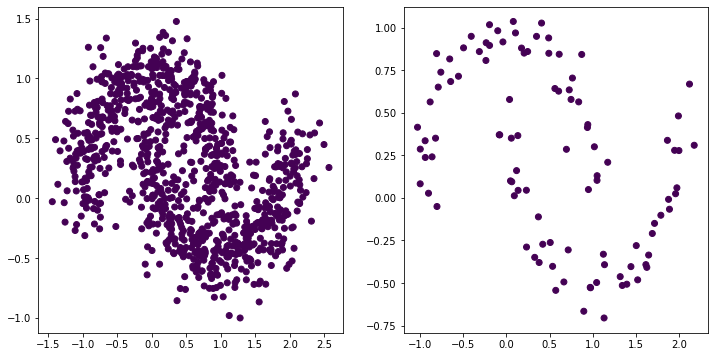

In [65]:
network.eval()   #   tell the network we are in evaluation mode (deactivates mini-batches, dropouts, etc)
with torch.no_grad():    # deactivates the autograd engine (to not safe grads, etc)
    a_train = network(X_train)
    a_test = network(X_test)
print("Test set accuracy: ", accuracy_score(y_test, np.where(a_test[:, 0].numpy()>0.5, 1, 0)))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=np.where(a_train[:, 0].numpy()>0.5, 1, 0))
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=np.where(a_test[:, 0].numpy()>0.5, 1, 0))